# Acceleration of a FIR filter on the Pynq-Z2

This script shows how to accelerate a Python function using the Pynq projet. We will first see how the software implementation performs and then compare it performance with a custon Overlay.

This work is heavily inspired by this article https://www.fpgadeveloper.com/2018/03/how-to-accelerate-a-python-function-with-pynq.html/

## Helper function for plotting

We will use this function to plot signals and choose the number of samples to limit RAM usage.


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None, out_label='FIR output'):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    
    # plotting time axis in 
    plt.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'y-', label='Input signal')
    
    # if an output signal is given as an argument plot it
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'g-', linewidth=2, label=out_label)
    
    plt.legend(loc='upper right')

## Generate the input signal

This code will generate a "noisy" singal that will be used as an input to our FIR filter. The main signal is a 200kHZ sinusoid to which we add 2 sinusoids of lower amplitude at 48Mhz and 12Mhz to simualte noise. 

(Real) Number of samples: 200000


<IPython.core.display.Javascript object>


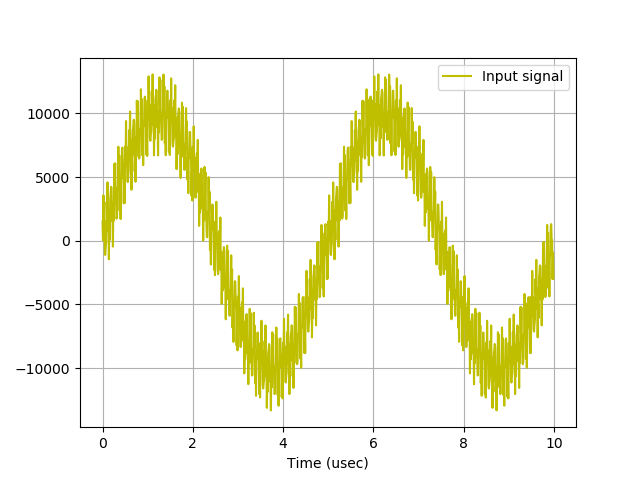

In [2]:
import numpy as np

# Total time
T = 0.002
# Sampling frequency
fs = 100e6
#number of samples
n = int(T * fs)
#Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
#samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t)+2000*np.sin(12e6*2*np.pi*t)
#Convert samples to 32-bit int
samples = samples.astype(np.int32)
print('(Real) Number of samples:', len(samples))

#Plot signal to the notebook
plot_to_notebook(t,samples,1000)

## Software implementation of the FIR filter

We will be using SciPy and its `lfilter` function to filter the "noisy" signal generated above. The SciPy documenation for `scipy.signal.lfilter(b, a, x)` states that for a 1D signal `x` with `b` the numerator coefficient vector and `a` the denominator coefficient vector. They were obtained from http://t-filter.engineerjs.com/


In [4]:
from scipy.signal import lfilter

coeffs = [
    -255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,
    4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255
]

import time
start_time = time.time()
sw_fir_output = lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR exec time:', sw_exec_time)

#Plot the res to notebook
plot_to_notebook(t,samples,1000,out_signal = sw_fir_output)

Software FIR exec time: 0.0859227180480957


<IPython.core.display.Javascript object>

## Hardware FIR implementation

After putting the .bit file and the .hwh file in the a folder and giving them the same name 
(here `fir_accel.bit` and `fir_accel.hwh`). We can use this IP as an overlay.

In [3]:
from pynq import Overlay
import pynq.lib.dma

# load the overlay
overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')

# load the FIR DMA
dma = overlay.filter.fir_dma

In [6]:
# from pynq import Xlnk
import numpy as np
from pynq import allocate

# Allocate buffers for the input and output signals
# xlnk = Xlnk()

# here n is the number samples as defined above
#in_buff = xlnk.cma_array(shape=(n,), dtype=np.int32)
#out_buff = xlnk.cma_array(shape=(n,), dtype=np.int32)

in_buff = allocate(shape=(n,), dtype=np.int32)
out_buff = allocate(shape=(n,), dtype=np.int32)
# Copy the samples to the in_buffer
np.copyto(in_buff, samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buff)
dma.recvchannel.transfer(out_buff)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time - start_time

print("Hardware FIR execution time: ", hw_exec_time)
print("Hardware acceleration factor", sw_exec_time / hw_exec_time)

# plotting
plot_to_notebook(t, samples, 1000, out_signal=out_buff, out_label="Hardware FIR output")



Hardware FIR execution time:  0.005146980285644531
Hardware acceleration factor 16.693811376690753


<IPython.core.display.Javascript object>

## Creating a driver for FIR accelerator

To make the use of this IP easier and hide the inner-workings of the DMA to the user. We will need to create a class inheriting from `DefaultHierarchy`.

In [7]:
from pynq import DefaultHierarchy
from pynq import allocate

class FirDriver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)
    
    def fir_filter(self, data):
        in_buff  = allocate(shape=(len(data),), dtype=np.int32)
        out_buff = allocate(shape=(len(data),), dtype=np.int32)
        np.copyto(in_buff, data)
        self.fir_dma.sendchannel.transfer(in_buff)
        self.fir_dma.recvchannel.transfer(out_buff)
        self.fir_dma.sendchannel.wait()
        self.fir_dma.recvchannel.wait()
        in_buff.freebuffer()
        out_buff.freebuffer()
        result = out_buff.copy()
        return out_buff
    
    @staticmethod
    def checkhierarchy(description):
        return 'fir_dma' in description['ip']
                

In [ ]:
from pynq import Overlay
import pynq.lib.dma

overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')
import time
start_time = time.time()
result = overlay.filter.fir_filter(samples)
stop_time = time.time()
hw_exec_time = stop_time - start_time
print("Hardware FIR execution time (with allocation): ", hw_exec_time)
print("Hardware acceleration factor (with allocation): ", sw_exec_time / hw_exec_time)

# plot to the notebook
plot_to_notebook(t, samples, 1000, out_signal=result)

## NOTE :

Compared to the tutorial from fpgadevelopper few things have changed :
    - Adding plt.legend(loc='upper right') to the plot function to show the legend
    - You need to have a .hwh alongside your bitstream
    - Xlnk is deprecated (for contiguous memory allocation you need to use allocate)
    - You can't use the "with ... as ..." synthax when using PynqBuffer as it uses free_buffer() instead of freebuffer()

In [ ]:
from cffi import FFI
ffibuilder = FFI()

from pynq import DefaultHierarchy
from pynq import allocate
from pynq.buffer import PynqBuffer

import numpy as np
class ffiBuffer(PynqBuffer):
    _G_KEEPALIVE = set()
    TYPE_LUT = {
        np.int   : "int",
        np.float : "float",
        np.uint8 : "unsigned char"    
    }
    
    def __init__(self, cdata, dtype, ffibuilder):
        super().__init__()
        self._cdata = cdata
        self._builder = ffibuilder
        self._dtype = dtype
        ffiBuffer._G_KEEPALIVE.add(self)
        
        self.nbytes = self._builder.sizeof(self._cdata)
        self.physical_address = self._builder.addressof(self._cdata)
    
    def __index__(self):
        return 1
        
    def as_array(self):
        backend_buff = self._builder.buffer(self._cdata, self.nbytes)
        PynqBuffer(np.frombuffer(backend_buff, dtype=self._dtype))
        return PynqBuffer(
        
    def flush(self):
        # compatibility
        return
    
    @staticmethod
    def allocate(ffib, shape, dtype ):
        
        if dtype in ffiBuffer.TYPE_LUT :
            str_ctype = ffiBuffer.TYPE_LUT[dtype]
            str_suffix = "".join([f"[{i}]" for i in shape])
            bckend_new = ffib.new(f"{str_ctype}"+str_suffix) 
            return ffiBuffer(bckend_new, dtype, ffib)
        
        else :
            raise NotImplementedError(f"dtype {dtype} is not implemented ! You can modify ffiBuffer.TYPE_LUT to add your numpy dtype and c equivalent.")

from .pl_server import Device            
def myallocate(shape, dtype, target=None, **kwargs):
    device = Device.active_device
            
            
class FirDriver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description)
    
    def fir_filter(self, data):
        in_buff  = allocate(shape=(len(data),), dtype=np.int32)
        out_buff = allocate(shape=(len(data),), dtype=np.int32)
        np.copyto(in_buff, data)
        self.fir_dma.sendchannel.transfer(in_buff.as_array())
        self.fir_dma.recvchannel.transfer(out_buff.as_array())
        self.fir_dma.sendchannel.wait()
        self.fir_dma.recvchannel.wait()
        in_buff.freebuffer()
        out_buff.freebuffer()
        result = out_buff.copy()
        return out_buff
        
    @staticmethod
    def checkhierarchy(description):
        return 'fir_dma' in description['ip']

from pynq import Overlay
import pynq.lib.dma

overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')
import time
start_time = time.time()
result = overlay.filter.cffi_fir_filter(samples)
stop_time = time.time()
hw_exec_time = stop_time - start_time
print("Hardware FIR execution time (with allocation): ", hw_exec_time)
print("Hardware acceleration factor (with allocation): ", sw_exec_time / hw_exec_time)

# plot to the notebook
plot_to_notebook(t, samples, 1000, out_signal=result)